In [41]:
%load_ext autoreload
%autoreload 2
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
# add parent_path to path for imports
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
if not os.getcwd().endswith("kit_d-fine_sports-analytics"):
    os.chdir("..")


In [43]:
import src
from src import config
from src.models import ball_gain_prediction
from src.utils import db_handler, utils
from src.models.ball_gain_prediction import *
import sklearn
import seaborn as sns

In [44]:
target_set = "target_dataset_shift_2sec_hypothesis_testing"
target_dataset = db_handler.get_table(target_set)

In [45]:
middle_lane = target_dataset[target_dataset["lane_middle"] == 1]
third_defending = target_dataset[target_dataset["third_defending"] == 1]
third_attacking = target_dataset[target_dataset["third_attacking"] == 1]


In [46]:
print(f"Total rows: {target_dataset.shape[0]}")
print(f"Middle lane: {middle_lane.shape[0]}")
print(f"Middle lane ratio: {int((middle_lane.shape[0]/target_dataset.shape[0])*100)}%")

Total rows: 144922
Middle lane: 70240
Middle lane ratio: 48%


In [47]:
print(f"Total rows: {target_dataset.shape[0]}")
print(f"Third defending: {third_defending.shape[0]}")
print(f"Third defending: {int((third_defending.shape[0]/target_dataset.shape[0])*100)}%")

Total rows: 144922
Third defending: 47842
Third defending: 33%


In [48]:
print(f"Total rows: {target_dataset.shape[0]}")
print(f"Third attacking: {third_attacking.shape[0]}")
print(f"Third attacking: {int((third_attacking.shape[0]/target_dataset.shape[0])*100)}%")

Total rows: 144922
Third attacking: 48360
Third attacking: 33%


In [49]:
evaluation_cols =["target",
               "distance_to_the_ball_shift_0_sec_1_defenders",
               "numerical_superiority_20m_fromball_shift_0_sec_defending_team",
               "distance_to_the_ball_shift_0_sec_1_attackers",
               "numerical_superiority_10m_fromball_shift_0_sec_defending_team",
               "number_defenders_10m_fromball_shift_0_sec_defending_team",
               "number_defenders_20m_fromball_shift_0_sec_defending_team",
               "defensive_pressure_shift_0_sec_1_attackers",
               "velocity_shift_0_sec_1_attackers",
               "surface_area_shift_0_sec_attacking_team",
               "spread_team_shift_0_sec_attacking_team",
               "lane_middle",
              ]

In [50]:
def plot_plots(data, group_column, value_column):
    sns.boxplot(data = data, x = group_column, y = value_column)
    plt.show()
    sns.histplot(data=data, x=value_column, hue=group_column, bins=50, stat='density', common_norm=False)
    plt.show()
    sns.kdeplot(x=value_column, data=target_dataset, hue=group_column, common_norm=False)
    plt.show()

# statistics teams having the ball

In [51]:
target_dataset["top_6_has_ball"] = (((target_dataset["home_team_buli_top_6"]==1) & (target_dataset["home_team_is_in_possession"]==1)) |
                           ((target_dataset["away_team_buli_top_6"]==1) & (target_dataset["home_team_is_in_possession"]==0)) )
target_dataset["middle_6_has_ball"] = (((target_dataset["home_team_buli_middle_6"]==1)  & (target_dataset["home_team_is_in_possession"]==1))|
                              ((target_dataset["away_team_buli_middle_6"]==1)  & (target_dataset["home_team_is_in_possession"]==0)))
target_dataset["bottom_6_has_ball"] = (((target_dataset["home_team_buli_bottom_6"]==1) & (target_dataset["home_team_is_in_possession"]==1))|
                              ((target_dataset["away_team_buli_bottom_6"]==1) & (target_dataset["home_team_is_in_possession"]==0)))
target_dataset["buli_ball_pos"] = np.where(target_dataset["top_6_has_ball"],
                                          "top_6",
                                           np.where(target_dataset["middle_6_has_ball"], "middle_6", "bottom_6"),)

In [52]:
control = target_dataset["top_6_has_ball"] +  target_dataset["middle_6_has_ball"]  + target_dataset["bottom_6_has_ball"] 
(control == 1).all()

C:\Users\ResearchLab\miniconda3\envs\shap_tsg\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


True

In [53]:
print(f"ball loss, when the top 6 have the ball: {target_dataset[target_dataset['top_6_has_ball']==1]['target'].mean().round(2)}")
print(f"ball loss, when the middle 6 have the ball: {target_dataset[target_dataset['middle_6_has_ball']==1]['target'].mean().round(2)}")
print(f"ball loss, when the bottom 6 have the ball: {target_dataset[target_dataset['bottom_6_has_ball']==1]['target'].mean().round(2)}")

Ballverluste, wenn die Top 6 den Ball haben: 0.14
Ballverluste, wenn die Middle 6 den Ball haben: 0.16
Ballverluste, wenn die Lower 6 den Ball haben: 0.17


Evaluating target


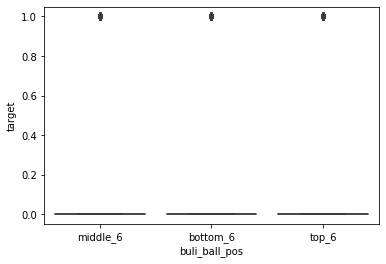

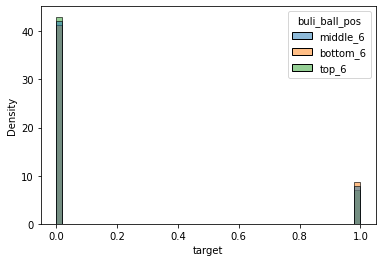

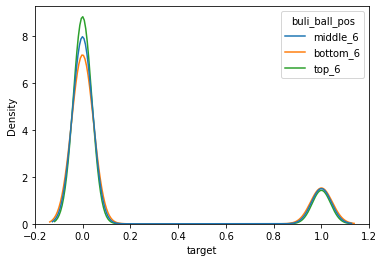

Evaluating distance_to_the_ball_shift_0_sec_1_defenders


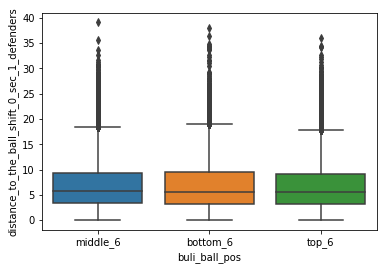

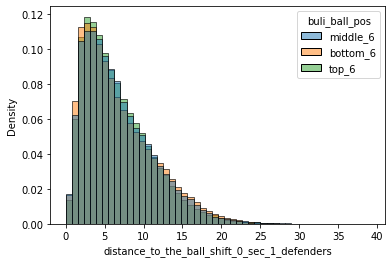

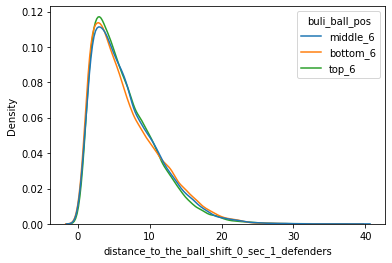

Evaluating numerical_superiority_20m_fromball_shift_0_sec_defending_team


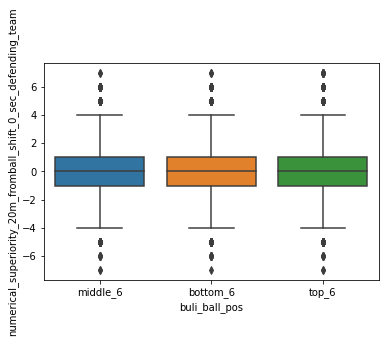

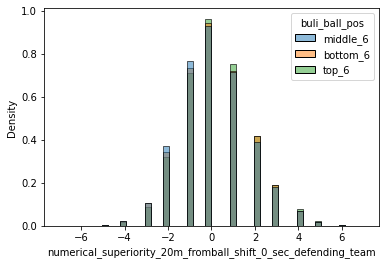

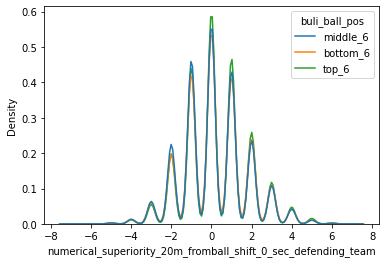

Evaluating distance_to_the_ball_shift_0_sec_1_attackers


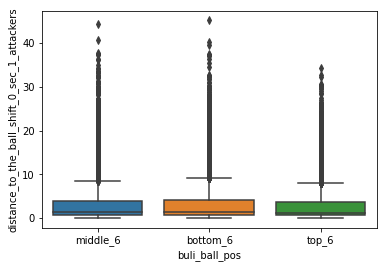

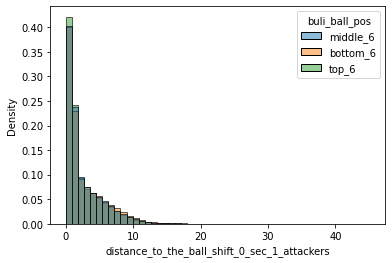

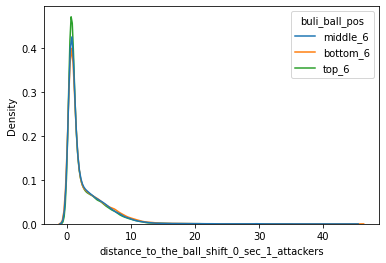

Evaluating numerical_superiority_10m_fromball_shift_0_sec_defending_team


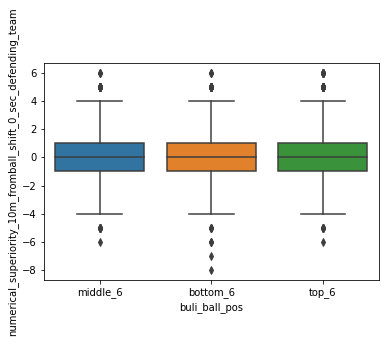

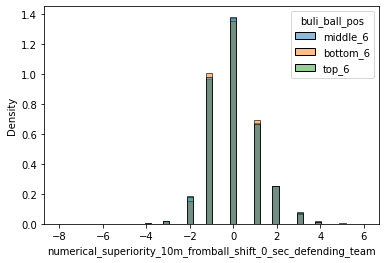

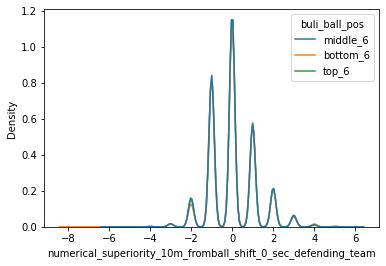

Evaluating number_defenders_10m_fromball_shift_0_sec_defending_team


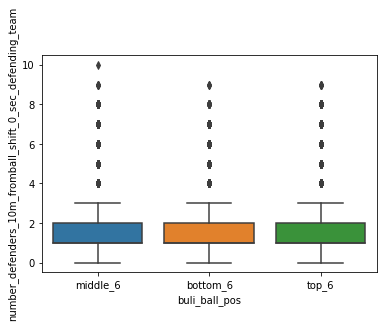

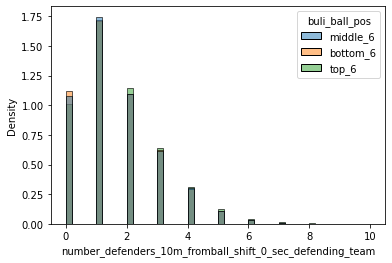

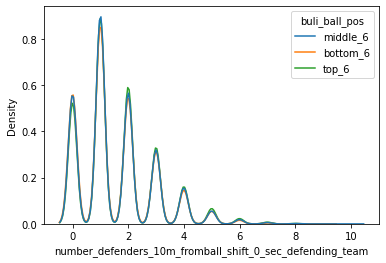

Evaluating number_defenders_20m_fromball_shift_0_sec_defending_team


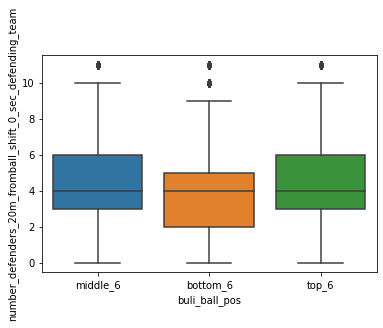

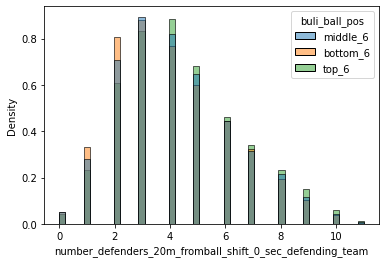

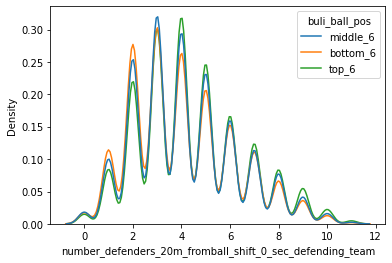

Evaluating defensive_pressure_shift_0_sec_1_attackers


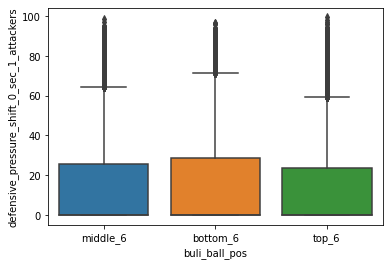

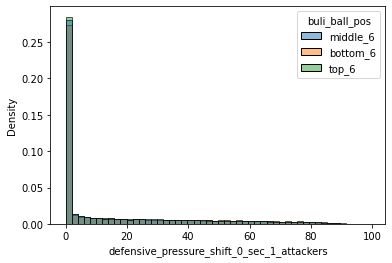

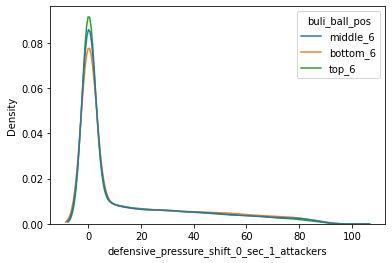

Evaluating velocity_shift_0_sec_1_attackers


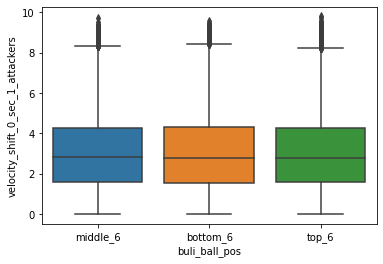

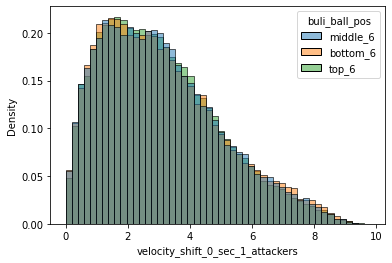

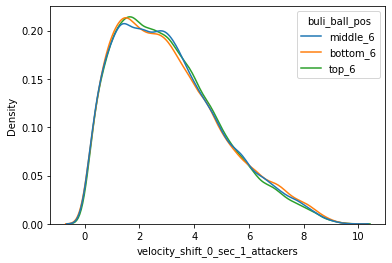

Evaluating surface_area_shift_0_sec_attacking_team


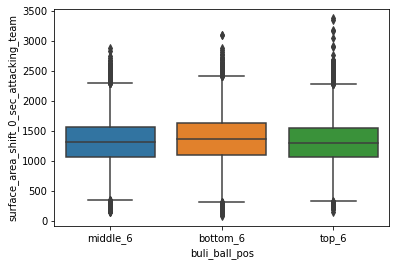

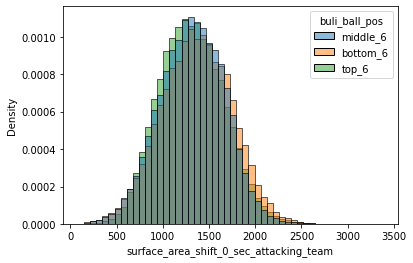

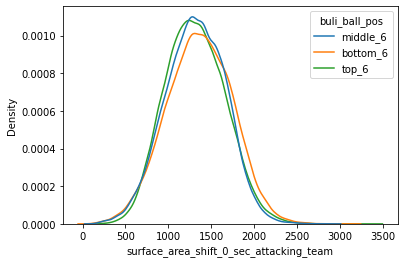

Evaluating spread_team_shift_0_sec_attacking_team


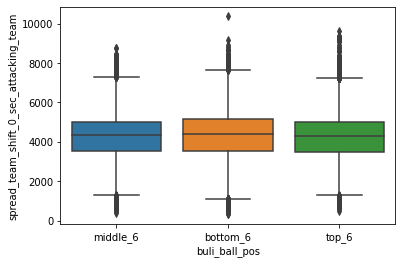

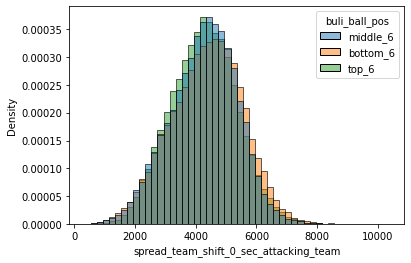

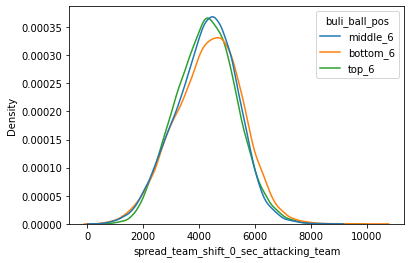

Evaluating lane_middle


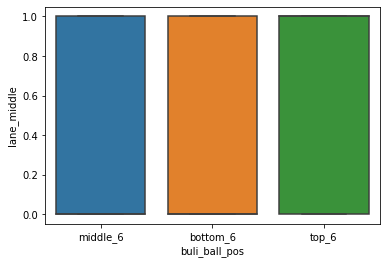

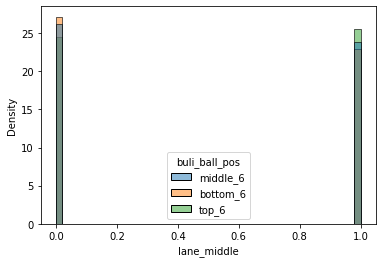

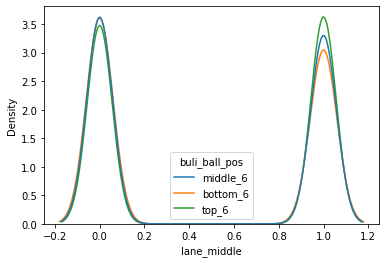

In [54]:
for column in evaluation_cols:
    print(f"Evaluating {column}")
    plot_plots(data=target_dataset, value_column=column, group_column='buli_ball_pos')

# statistics on teams defending the ball

In [55]:
target_dataset["top_6_defending_ball"] = (((target_dataset["home_team_buli_top_6"]==1) & (target_dataset["home_team_is_in_possession"]==0)) |
                           ((target_dataset["away_team_buli_top_6"]==1) & (target_dataset["home_team_is_in_possession"]==1)) )
target_dataset["middle_6_defending_ball"] = (((target_dataset["home_team_buli_middle_6"]==1)  & (target_dataset["home_team_is_in_possession"]==0))|
                              ((target_dataset["away_team_buli_middle_6"]==1)  & (target_dataset["home_team_is_in_possession"]==1)))
target_dataset["bottom_6_defending_ball"] = (((target_dataset["home_team_buli_bottom_6"]==1) & (target_dataset["home_team_is_in_possession"]==0))|
                              ((target_dataset["away_team_buli_bottom_6"]==1) & (target_dataset["home_team_is_in_possession"]==1)))
target_dataset["buli_defending_team"] = np.where(target_dataset["top_6_defending_ball"],
                                          "top_6",
                                           np.where(target_dataset["middle_6_defending_ball"], "middle_6", "bottom_6"),)

In [88]:
print(f"ball losses, when the top 6 are defending: {target_dataset[target_dataset['top_6_defending_ball']==1]['target'].mean().round(3)}")
print(f"ball losses, when the middle 6 are defending: {target_dataset[target_dataset['middle_6_defending_ball']==1]['target'].mean().round(3)}")
print(f"ball losses, when the bottom 6 are defendin: {target_dataset[target_dataset['bottom_6_defending_ball']==1]['target'].mean().round(3)}")

Ballverluste, wenn die Top 6 den Ball verteidigen: 0.18
Ballverluste, wenn die Middle 6 den Ball verteidigen: 0.15
Ballverluste, wenn die Lower 6 den Ball verteidigen: 0.143


Evaluating target


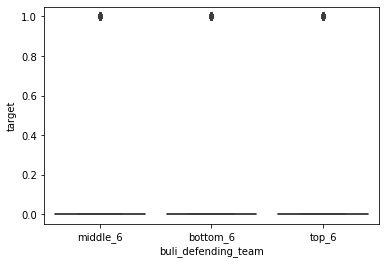

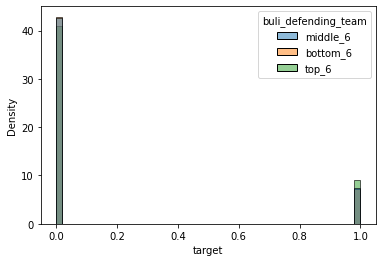

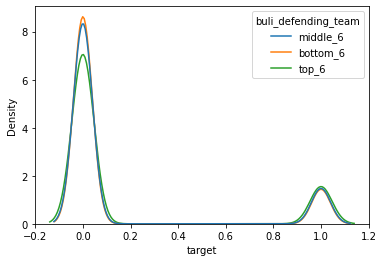

Evaluating distance_to_the_ball_shift_0_sec_1_defenders


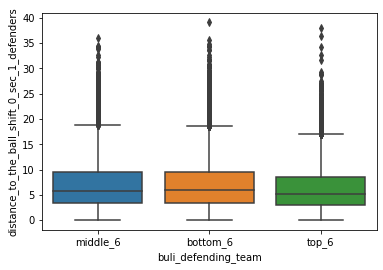

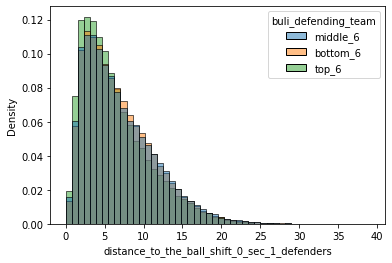

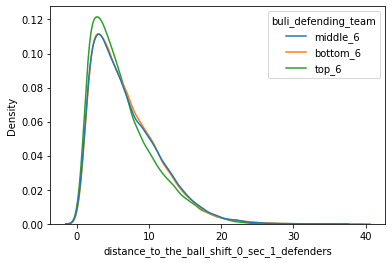

Evaluating numerical_superiority_20m_fromball_shift_0_sec_defending_team


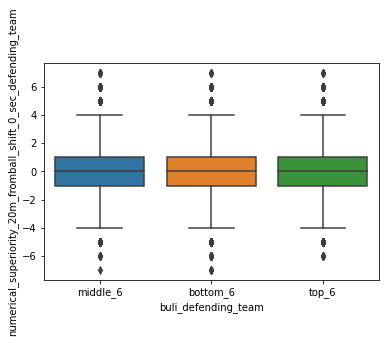

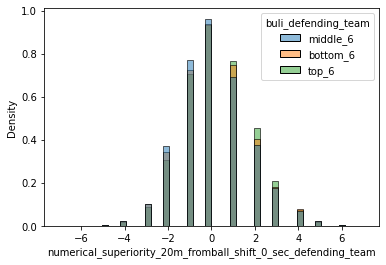

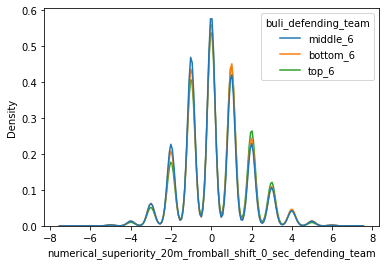

Evaluating distance_to_the_ball_shift_0_sec_1_attackers


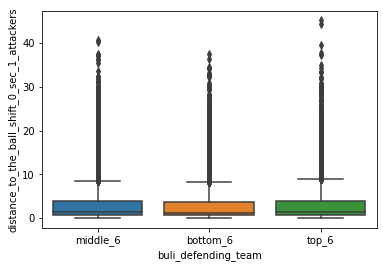

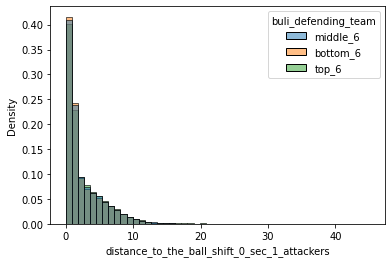

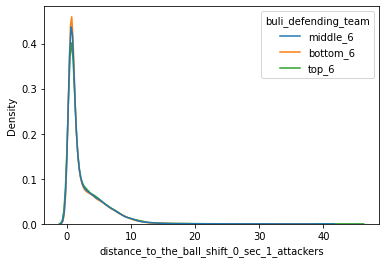

Evaluating numerical_superiority_10m_fromball_shift_0_sec_defending_team


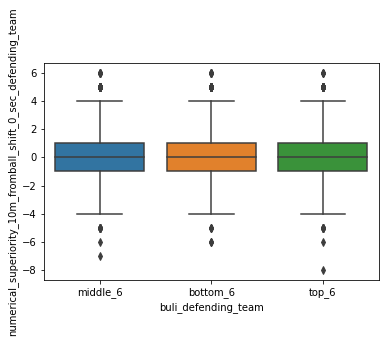

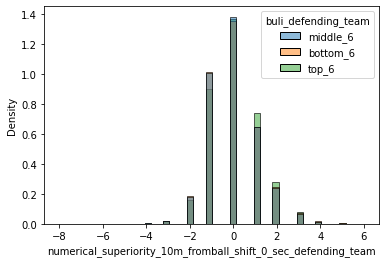

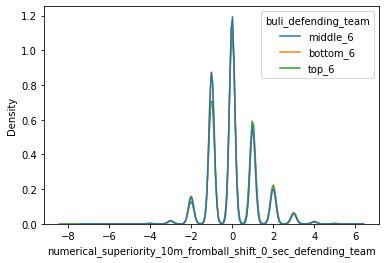

Evaluating number_defenders_10m_fromball_shift_0_sec_defending_team


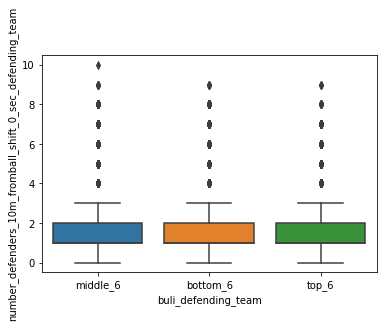

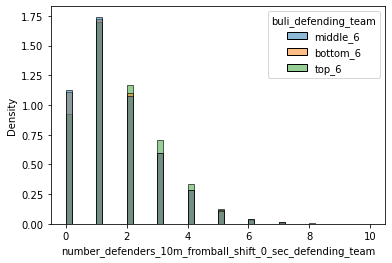

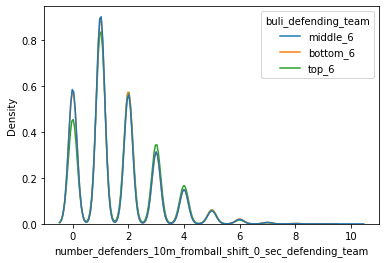

Evaluating number_defenders_20m_fromball_shift_0_sec_defending_team


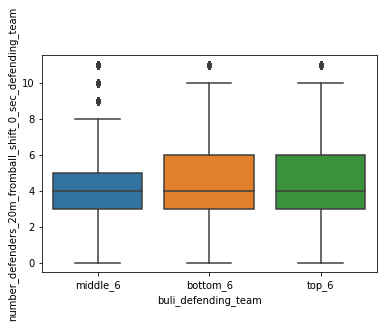

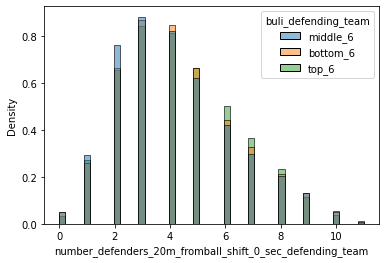

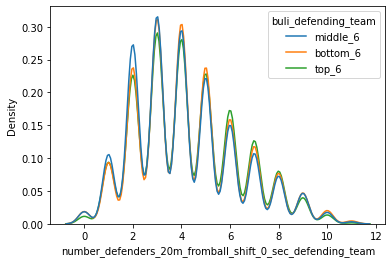

Evaluating defensive_pressure_shift_0_sec_1_attackers


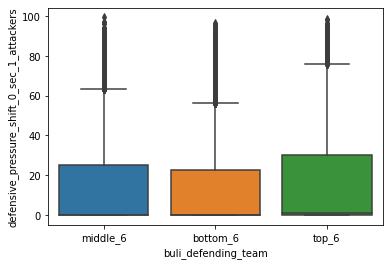

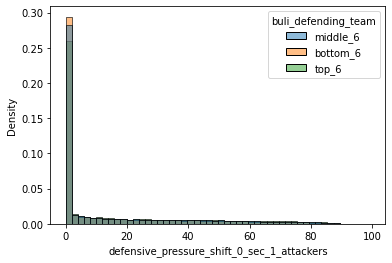

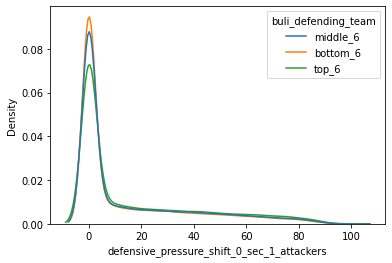

Evaluating velocity_shift_0_sec_1_attackers


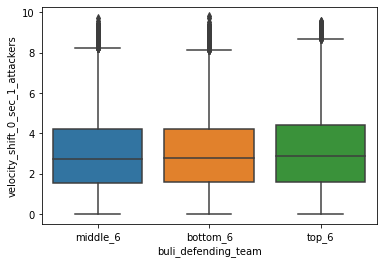

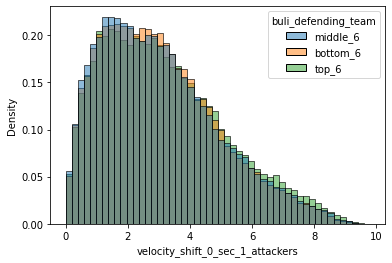

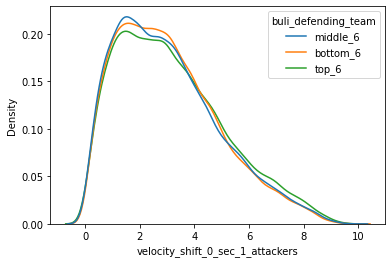

Evaluating surface_area_shift_0_sec_attacking_team


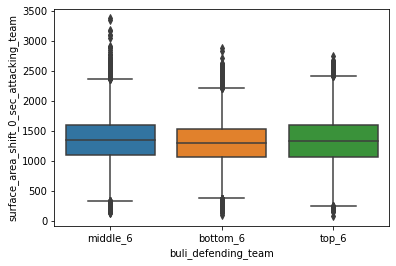

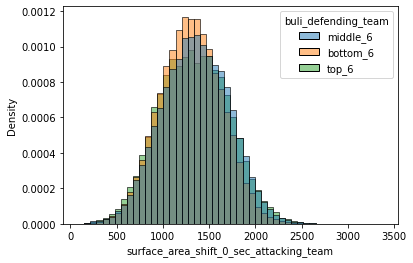

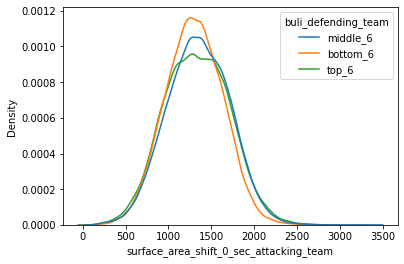

Evaluating spread_team_shift_0_sec_attacking_team


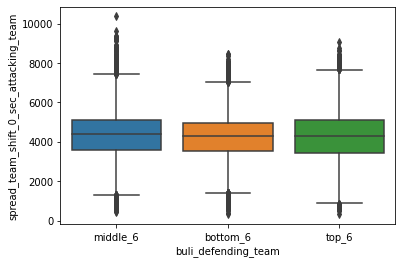

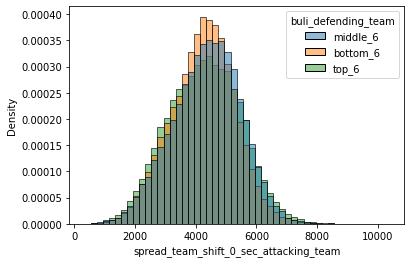

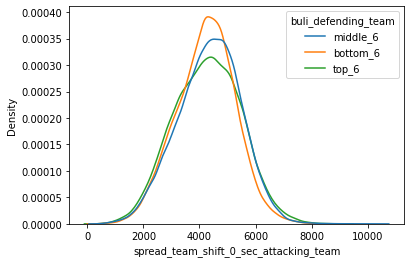

Evaluating lane_middle


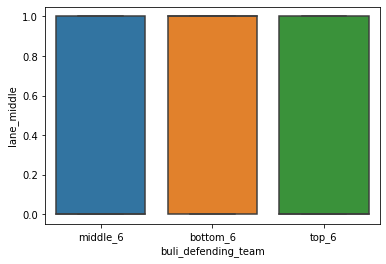

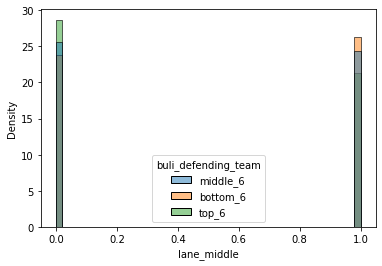

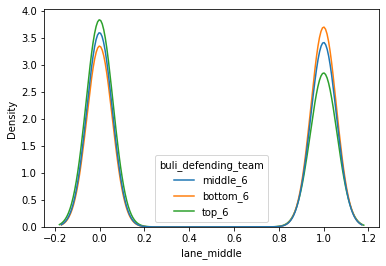

In [57]:
for column in evaluation_cols:
    print(f"Evaluating {column}")
    plot_plots(data=target_dataset, value_column=column, group_column='buli_defending_team')

# simple stats

In [78]:
top_6_defending = target_dataset[target_dataset["buli_defending_team"] == "top_6"]
bottom_12_defending = target_dataset[target_dataset["buli_defending_team"] != "top_6"]
print("top_6_defending")
print(top_6_defending.shape)
print("bottom_12_defending")
print(bottom_12_defending.shape)
bottom_6_defending = target_dataset[target_dataset["buli_defending_team"] == "bottom_6"]
print("bottom_6_defending")
print(bottom_6_defending.shape)

top_6_defending
(39110, 386)
bottom_12_defending
(105812, 386)
bottom_6_defending
(53498, 386)


In [79]:
round((top_6_defending["distance_to_the_ball_shift_0_sec_1_defenders"] < 10).sum()/top_6_defending.shape[0],2)

0.82

In [80]:
round((bottom_6_defending["distance_to_the_ball_shift_0_sec_1_defenders"] < 10).sum()/bottom_6_defending.shape[0],2)

0.78

<AxesSubplot:xlabel='distance_to_the_ball_shift_0_sec_1_defenders', ylabel='Proportion'>

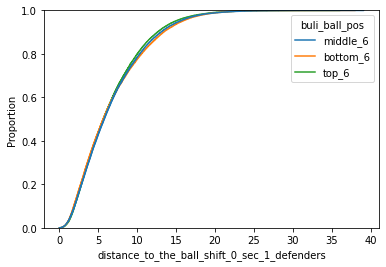

In [81]:
sns.ecdfplot(x="distance_to_the_ball_shift_0_sec_1_defenders", data=target_dataset, hue="buli_ball_pos")

In [86]:
round((top_6_defending["distance_to_the_ball_shift_0_sec_1_defenders"] < 3).sum()/top_6_defending.shape[0],3)

0.247

In [87]:
round((bottom_6_defending["distance_to_the_ball_shift_0_sec_1_defenders"] < 3).sum()/bottom_6_defending.shape[0],3)

0.21

In [84]:
round((top_6_defending["distance_to_the_ball_shift_0_sec_1_defenders"] < 1).sum()/top_6_defending.shape[0],2)

0.03

In [85]:
round((bottom_6_defending["distance_to_the_ball_shift_0_sec_1_defenders"] < 1).sum()/bottom_6_defending.shape[0],2)

0.02

In [90]:
round((top_6_defending["numerical_superiority_20m_fromball_shift_0_sec_defending_team"] < 0).sum()/top_6_defending.shape[0],3)

0.313

In [91]:
round((bottom_6_defending["numerical_superiority_20m_fromball_shift_0_sec_defending_team"] < 0).sum()/bottom_6_defending.shape[0],3)

0.335

In [98]:
for i in range(-4, 6):
    print(f'Top 6 greater {i}: {round((top_6_defending["numerical_superiority_20m_fromball_shift_0_sec_defending_team"] > i).sum()/top_6_defending.shape[0],3)}')
    print(f'Bottom 6 greater {i}: {round((bottom_6_defending["numerical_superiority_20m_fromball_shift_0_sec_defending_team"] > i).sum()/bottom_6_defending.shape[0],3)}')

Top 6 greater -4: 0.994
Bottom 6 greater -4: 0.992
Top 6 greater -3: 0.969
Bottom 6 greater -3: 0.963
Top 6 greater -2: 0.884
Bottom 6 greater -2: 0.867
Top 6 greater -1: 0.687
Bottom 6 greater -1: 0.665
Top 6 greater 0: 0.426
Bottom 6 greater 0: 0.402
Top 6 greater 1: 0.212
Bottom 6 greater 1: 0.193
Top 6 greater 2: 0.084
Bottom 6 greater 2: 0.08
Top 6 greater 3: 0.025
Bottom 6 greater 3: 0.029
Top 6 greater 4: 0.005
Bottom 6 greater 4: 0.008
Top 6 greater 5: 0.001
Bottom 6 greater 5: 0.001
